<a href="https://colab.research.google.com/github/julichitai/learning_NN/blob/NLP/text_classification_NLP_SAMSUNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Тематическая классификация длинных текстов - TFIDF и LogReg¶


In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 1.7MB 23.0MB/s 
     |████████████████████████████████| 24.2MB 1.3MB/s 
     |████████████████████████████████| 307kB 49.5MB/s 
     |████████████████████████████████| 8.2MB 47.2MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7554083728a8e0fe2e51b5b4d02d2e58f5ffb873771addc64581514841ff7a6c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625174 sha256=7420723c427edea6b8f061

In [195]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import numpy as np
import scipy

from tqdm import tqdm
import nltk

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils

# from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, vectorize_texts, SparseFeaturesDataset, TOKEN_RE
# from dlnlputils.pipeline import train_eval_loop, init_random_seed, predict_with_model

from dlnlputils.pipeline import init_random_seed
from dlnlputils.data import TOKEN_RE


init_random_seed()

In [196]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

In [ ]:
TOKEN_RE

re.compile(r'[\w\d]+', re.UNICODE)

In [217]:
def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, is_lemm=False, is_stem=False):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tqdm(tokenized_texts):
        if is_stem:
            # nltk.stemmer.PorterStemmer()
            sno = nltk.stem.SnowballStemmer('english')
            stem_txt = [sno.stem(i) for i in txt]
            txt = stem_txt
        if is_lemm:
            lemma = nltk.wordnet.WordNetLemmatizer()
            lemm_txt = [lemma.lemmatize(i) for i in txt]
            txt = lemm_txt

        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'pmi'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in tqdm(enumerate(tokenized_texts)):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    # точечной взаимной информации (PMI)
    elif mode == 'pmi':
      sum_of_sizes_of_docs = np.array(result.sum())
      sizes_of_every_doc = np.array(result.sum(1))
      count_word_in_docs = np.array(result.sum(0))
      result = result.multiply((sum_of_sizes_of_docs**2)/((sizes_of_every_doc**2) * count_word_in_docs))
      result.data = np.log(result.data)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [198]:
from torch.utils.data import Dataset


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [199]:
from torch.utils.data import DataLoader
import datetime 
import copy


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [200]:
def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

### Предобработка текстов и подготовка признаков


In [201]:
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_data['data']))
print('Количество тестовых текстов', len(test_data['data']))

print()
print(train_data['data'][0].strip())
print()
print('Имена целевых переменных', train_data['target_names'])
print('Метка', train_data['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Имена целевых переменных ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.spor

#### Подготовка признаков


In [202]:
train_tokenized = tokenize_corpus(train_data['data'])
test_tokenized = tokenize_corpus(test_data['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [243]:
import collections


MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized,
                                             max_doc_freq=MAX_DF,
                                             min_count=MIN_COUNT,
                                             is_lemm=False,
                                             is_stem=False)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

100%|██████████| 11314/11314 [00:00<00:00, 31947.43it/s]

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


In [244]:
len(vocabulary)

21628

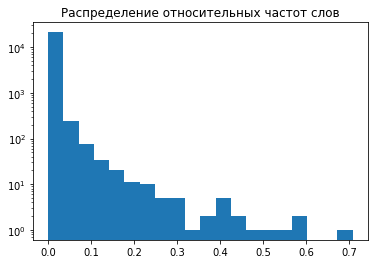

In [245]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [246]:
VECTORIZATION_MODE = 'pmi'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

11314it [00:41, 273.23it/s]
7532it [00:26, 285.79it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide


Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


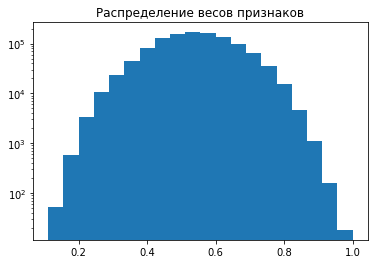

In [247]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [248]:
# del

texts = [
    'Казнить нельзя, помиловать. Нельзя наказывать.',
    'Казнить, нельзя помиловать. Нельзя освободить.',
    'Нельзя не помиловать.',
    'Обязательно освободить.'
]

tokenized = tokenize_corpus(texts, min_token_size=1)

word_df = [('нельзя', 0.75), ('помиловать', 0.75), ('казнить', 0.5),
 ('освободить', 0.5), ('наказывать', 0.25), ('не', 0.25), ('обязательно', 0.25)]

answer = sorted(word_df, key=lambda x:(x[1],x[0]))

answer_1 = []; 
answer_2 = [];

for k, v in list(answer):
    answer_1.append(k)
    answer_2.append(str(v))

# TF
matrix = np.zeros((len(texts), len(answer_1)))
for i, text in enumerate(tokenized):
    for j, token in enumerate(answer_1):
        if token in tokenized[i]:
            matrix[i][j] += text.count(token)
    matrix[i] /= len(text)

# IDF
size = len(texts)
counter_tokens = np.zeros(len(answer_1))
for i, token in enumerate(answer_1):
    for text in tokenized:
        if token in text:
            counter_tokens[i] += text.count(token)
counter_tokens = size / (counter_tokens + 1e-10)

# ln(TF + 1) * IDF
matrix = np.log(matrix + 1) * counter_tokens

# Standartization
feats_std = matrix.std(0, ddof=1)
feats_mean = np.mean(matrix, axis=0)
matrix = (matrix - feats_mean) / feats_std


for row in matrix:
    print(' '.join([str(i) for i in row]))

1.5000000000000002 -0.5 -0.5 0.8660254037844386 -0.7630125578876947 0.5954669471484166 0.1609678767201035
-0.5 -0.5 -0.5 0.8660254037844386 0.18368219185173845 0.5954669471484166 0.1609678767201035
-0.5 1.5 -0.5 -0.8660254037844386 -0.7630125578876947 0.29382391061831536 1.0424350837750262
-0.5 -0.5 1.5 -0.8660254037844386 1.3423429239236506 -1.4847578049151484 -1.3643708372152332


#### Распределение классов


In [249]:
UNIQUE_LABELS_N = len(set(train_data['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


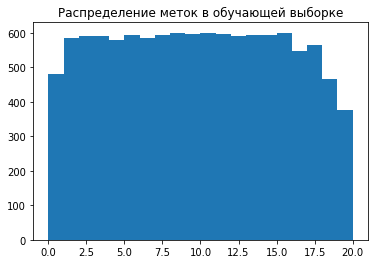

In [250]:
plt.hist(train_data['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

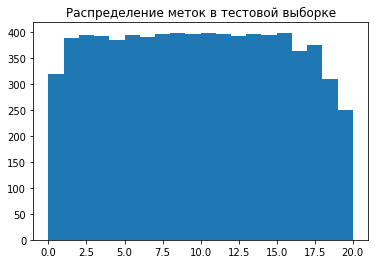

In [251]:
plt.hist(test_data['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

#### PyTorch Dataset


In [252]:
train_dataset = SparseFeaturesDataset(train_vectors, train_data['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_data['target'])

### Обучение модели на PyTorch


In [253]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)
batch_size = 32
best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=batch_size,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler,
                                            max_batches_per_epoch_train=len(train_dataset) // batch_size,
                                            max_batches_per_epoch_val=len(test_dataset) // batch_size)

Эпоха 0
Эпоха: 354 итераций, 1.81 сек
Среднее значение функции потерь на обучении 1.107504807075875
Среднее значение функции потерь на валидации 1.9285991661629434
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.74 сек
Среднее значение функции потерь на обучении 0.09613363615444433
Среднее значение функции потерь на валидации 2.061961509161076

Эпоха 2
Эпоха: 354 итераций, 1.72 сек
Среднее значение функции потерь на обучении 0.044606514301136393
Среднее значение функции потерь на валидации 2.0304274644892093

Эпоха 3
Эпоха: 354 итераций, 1.80 сек
Среднее значение функции потерь на обучении 0.03698849842874609
Среднее значение функции потерь на валидации 2.2358774301611772

Эпоха 4
Эпоха: 354 итераций, 1.77 сек
Среднее значение функции потерь на обучении 0.04849758947361053
Среднее значение функции потерь на валидации 2.067010013228756

Эпоха 5
Досрочно остановлено пользователем


### Оценка качества


In [254]:
train_predict = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_predict),
                             torch.from_numpy(train_data['target']))

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_data['target'], train_predict.argmax(axis=1)))
print()

test_predict = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_predict),
                            torch.from_numpy(test_data['target']))

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_data['target'], test_predict.argmax(axis=1)))

 99%|█████████▉| 351/353.5625 [00:01<00:00, 225.31it/s]/usr/local/lib/python3.6/dist-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 354/353.5625 [00:01<00:00, 226.03it/s]
 10%|▉         | 23/235.375 [00:00<00:00, 229.75it/s]

Среднее значение функции потерь на обучении 0.08887787908315659
Доля верных ответов 0.9852395262506629



236it [00:01, 225.20it/s]                             

Среднее значение функции потерь на валидации 1.9238135814666748
Доля верных ответов 0.7396441848114711


## Альтернативная реализация на scikit-learn


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


model_sk = Pipeline((
    ('vectorize', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                            max_df=MAX_DF,
                                            min_df=MIN_COUNT)),
    ('clsf', LogisticRegression())
))

model_sk.fit(train_data['data'], train_data['target'])

Pipeline(memory=None,
         steps=[('vectorize',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                                 tokenizer=<function tokenize_text_simple_regex at 0x7f053d3b4378>,
                                 use_idf=True, vocabulary=None)),
                ('clsf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    f

### Оценка качества


In [ ]:
train_predict = model_sk.predict_proba(train_data['data'])
train_loss = F.cross_entropy(torch.from_numpy(train_predict),
                             torch.from_numpy(train_data['target']))

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_data['target'], train_predict.argmax(axis=1)))
print()

test_predict = model_sk.predict_proba(test_data['data'])
test_loss = F.cross_entropy(torch.from_numpy(test_predict),
                            torch.from_numpy(test_data['target']))

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_data['target'], test_predict.argmax(axis=1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263
